Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import warnings
warnings.filterwarnings("ignore")

In [4]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
localPath = pathlib.Path.cwd()
localPath

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path(str(localPath) + "/Train/")
data_dir_test = pathlib.Path(str(localPath) + "/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

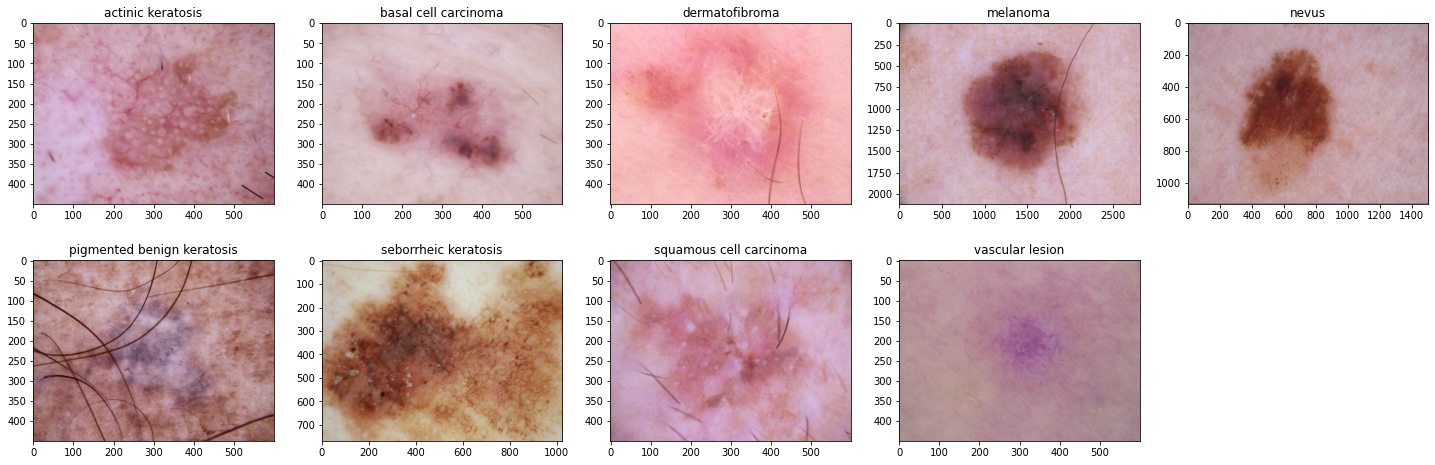

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 120s 406ms/step - loss: 2.1929 - accuracy: 0.1981 - val_loss: 2.0236 - val_accuracy: 0.2282
Epoch 2/20
56/56 [==============================] - 1s 12ms/step - loss: 1.8387 - accuracy: 0.3265 - val_loss: 1.6606 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 1s 12ms/step - loss: 1.6326 - accuracy: 0.4096 - val_loss: 1.5677 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 1s 12ms/step - loss: 1.5547 - accuracy: 0.4442 - val_loss: 1.4550 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 1s 12ms/step - loss: 1.4739 - accuracy: 0.4738 - val_loss: 1.4885 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 1s 12ms/step - loss: 1.4485 - accuracy: 0.5022 - val_loss: 1.3796 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 12ms/step - loss: 1.3620 - accuracy: 0.5117 - val_loss: 1.3759 - val_accuracy: 0.5168
Epoch 8/20

### Visualizing training results

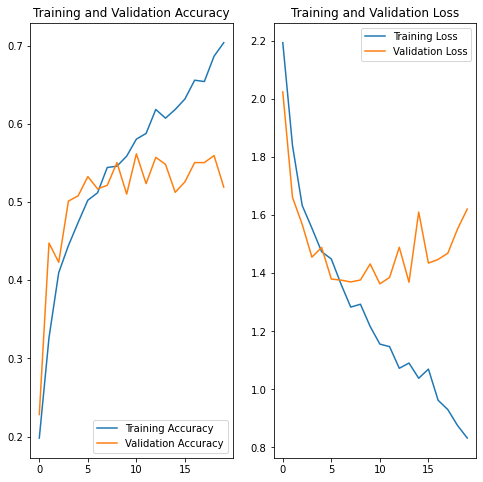

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis
#### Validation accuracy stops at 50 % accuracy.
#### See big difference between training and testing accuracy. Overfitting might have happened on training data.

### Data augmentation strategy 

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

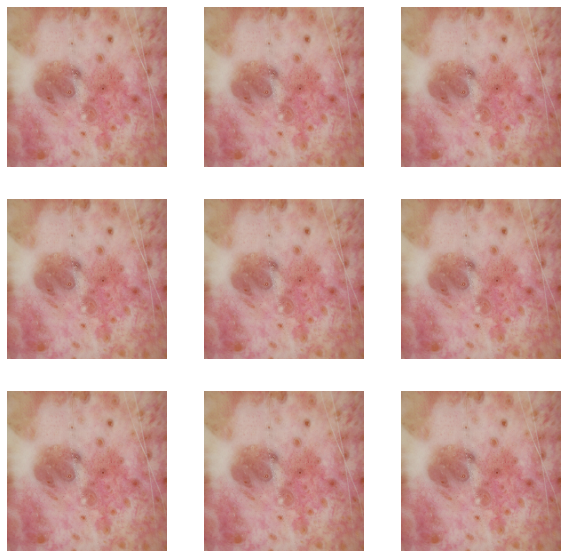

In [20]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [22]:
# Compiling the model
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [23]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 34ms/step - loss: 3.8775 - accuracy: 0.2316 - val_loss: 1.8799 - val_accuracy: 0.2550
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8197 - accuracy: 0.3393 - val_loss: 1.6507 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6283 - accuracy: 0.4090 - val_loss: 1.4987 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5662 - accuracy: 0.4353 - val_loss: 1.4869 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4461 - accuracy: 0.4860 - val_loss: 1.4626 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3735 - accuracy: 0.5106 - val_loss: 1.4787 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4188 - accuracy: 0.4994 - val_loss: 1.4508 - val_accuracy: 0.5078
Epoch 8/20
56

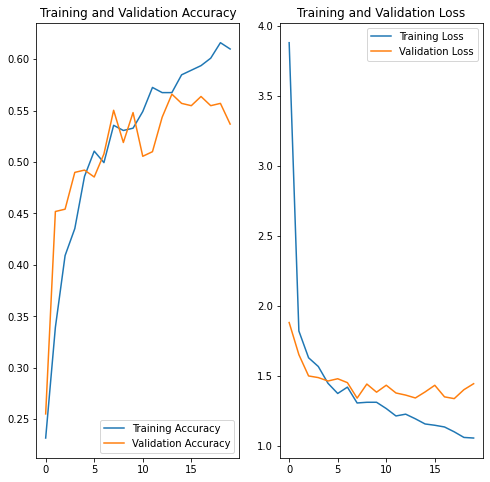

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis
#### Overfitting is reduced as the difference between trainf and test data accuracy is less.
#### data augumentation helped in reducing overfitting


In [25]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


### Visualizing the results

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:

path_to_training_dataset=str(data_dir_train) + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7B5819FB20>: 100%|██████████| 500/500 [00:03<00:00, 126.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AA79C0850>: 100%|██████████| 500/500 [00:04<00:00, 124.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7AA7B052B0>: 100%|██████████| 500/500 [00:04<00:00, 108.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7B580F3850>: 100%|██████████| 500/500 [00:18<00:00, 26.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F7AA88E6070>: 100%|██████████| 500/500 [00:15<00:00, 33.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AA86034F0>: 100%|██████████| 500/500 [00:04<00:00, 124.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7B5811B1C0>: 100%|██████████| 500/500 [00:07<00:00, 65.51 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7B58341FD0>: 100%|██████████| 500/500 [00:03<00:00, 125.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AA8829910>: 100%|██████████| 500/500 [00:04<00:00, 123.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026941.jpg_e3180669-5053-418d-a682-4f89dd8f9bc0.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025874.jpg_0a969a1e-dba0-4f1d-afec-786618658e59.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025781.jpg_a01a2987-a8f5-4d0f-8643-2d9c16ed2fc3.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025389.jpg_a0e674c5-59fa-4573-8a6f-06da76a52e8c.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028646.jpg_32e05386-659c-44cb-b8bf-e6f1b8072105.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025554.jpg_d2491dd2-0b4e-48ed-afdd-9b96081cae20.jpg',
 '/c

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [33]:
#new_df['Label'].value_counts()
df2['Path'].value_counts()

/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026941.jpg_e3180669-5053-418d-a682-4f89dd8f9bc0.jpg    1
/content/gdrive/MyDrive/CNN/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032135.jpg_336efb11-befa-4995-b3ad-604f9560a9fc.jpg                      1
/content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026152.jpg_f4c35b8f-d0c7-4efe-9955-d0a6f4541073.jpg          1
/content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_57193e29-26c3-470e-89fd-264c13ff5243.jpg          1
/content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026362.jpg_d0baf818-0380-42c3-8779-2d852354bfbd.jpg          1
                                                                                                                                                                    .

In [34]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [38]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 128)      

#### Compile your model (Choose optimizer and loss function appropriately)

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 128)      

#### Train your model

In [40]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 11s 63ms/step - loss: 1.8881 - accuracy: 0.2836 - val_loss: 1.5261 - val_accuracy: 0.4321
Epoch 2/30
169/169 [==============================] - 10s 58ms/step - loss: 1.5290 - accuracy: 0.4184 - val_loss: 1.4237 - val_accuracy: 0.4707
Epoch 3/30
169/169 [==============================] - 10s 58ms/step - loss: 1.4042 - accuracy: 0.4664 - val_loss: 1.2212 - val_accuracy: 0.5523
Epoch 4/30
169/169 [==============================] - 10s 57ms/step - loss: 1.2873 - accuracy: 0.5111 - val_loss: 1.1787 - val_accuracy: 0.5627
Epoch 5/30
169/169 [==============================] - 10s 58ms/step - loss: 1.1445 - accuracy: 0.5651 - val_loss: 1.0792 - val_accuracy: 0.6036
Epoch 6/30
169/169 [==============================] - 10s 57ms/step - loss: 1.0653 - accuracy: 0.6014 - val_loss: 1.0949 - val_accuracy: 0.6021
Epoch 7/30
169/169 [==============================] - 10s 57ms/step - loss: 0.9905 - accuracy: 0.6320 - val_loss: 0.9675 - val_accuracy:

#### Visualize the model results

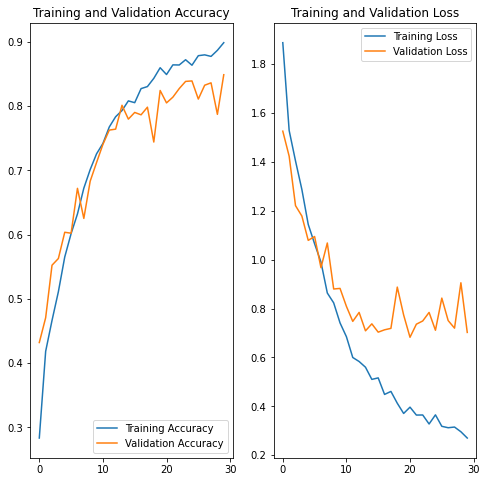

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis
#### Accuracy is improved to 0.8 in Test-data
#### Augmentor helped in getting better accuracy
#### Loss has come down too